### LDA (Линейный Дискриминантный анализ)  
Внутреннее устройство линейного дискриминантного анализа
1. Стандартизировать d-мерный набор исходных данных (d - количество признаков)
2. Для каждого класса вычислить d-мерный вектор средних
3. Построить матрицу рассеяния между классами S_B и матрицу рассеяния внутри классов S_W
4. Вычислить собственные векторы и соответствующие собственные значения матрицы (S_W.inv).dot(S_B)
5. Отсортировать собственные значения в порядке убывания, чтобы ранжировать соответствующие собственные векторы
6. Выбрать k-собственных векторов, которые соответствуют k наибольшим собственным значениям, чтобы построить d * k -мерную матрицу трансформации W; собственные векторы будут столбцами этой матрицы
7. Спроецировать образцы в новое подпространство признаков, используя матрицу трансформации W

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [2]:
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)

In [3]:
X,y = data.iloc[:, 1:].values, data.iloc[:, 0].values

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)


In [5]:
sc = StandardScaler()
# Стандартизируем, приведя к единичной дисперсии
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [17]:
np.set_printoptions(precision=4)
mean_vecs = []
# Вычисление векторов средних, которые будут применяться при построении матрицы рассеяния внутри классов и матрицы рассеяния
# между классами
for label in range(1,4):
    mean_vecs.append(np.mean(X_train_std[y_train==label],axis=0))
print(mean_vecs)

[array([ 0.9066, -0.3497,  0.3201, -0.7189,  0.5056,  0.8807,  0.9589,
       -0.5516,  0.5416,  0.2338,  0.5897,  0.6563,  1.2075]), array([-0.8749, -0.2848, -0.3735,  0.3157, -0.3848, -0.0433,  0.0635,
       -0.0946,  0.0703, -0.8286,  0.3144,  0.3608, -0.7253]), array([ 0.1992,  0.866 ,  0.1682,  0.4148, -0.0451, -1.0286, -1.2876,
        0.8287, -0.7795,  0.9649, -1.209 , -1.3622, -0.4013])]


In [18]:
# Используя векторы средних, вычислим матрицу рассеяния внутри классов S_W (суммируем индивидуальные матрицы рассеяния каждого отдельного класса)
d = 13
S_W = np.zeros((d,d))
for label, mv in zip(range(1,4), mean_vecs):
    class_scatter = np.zeros((d,d))
    for row in X_train_std[y_train==label]:
        row,mv = row.reshape(d,1), mv.reshape(d,1)
        class_scatter += (row-mv).dot((row-mv).T)
    S_W += class_scatter

In [34]:
# После вычисления матрицы рассеяния предполагаем, что в обучающем наборе равномерное распределение классов, однако это не так
print('Распределение меток класса: %s' % np.bincount(y_train)[1:])

Распределение меток класса: [41 50 33]


Таким образом, мы хотим масштабировать индивидуальные матрицы рассеяния отдельных классов перед их суммированием.
Можно заметить, что вычисление матрицы рассеяния фактически будет таким же, как вычисление ковариационной матрицы. 

In [20]:
d = 13
S_W = np.zeros((d,d))
for label,mv in zip(range(1,4), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train==label].T)
    S_W += class_scatter

Теперь вычислим матрицу рассеяния внутри между классами

In [21]:
mean_overall = np.mean(X_train_std, axis=0)
d = 13
S_B = np.zeros((d,d))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train[y_train == i + 1, :].shape[0]
    mean_vec = mean_vec.reshape(d,1)
    mean_overall = mean_overall.reshape(d,1)
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)

Далее получаем собственные векторы и собственные значения матрицы (S_W.inv).dot(S_B)

In [22]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

In [24]:
# Сортируем полученные значения в порядку убывания
eigen_pairs = [(np.abs(eigen_vals[i]),eigen_vecs[:,i]) for i in range(len(eigen_vals))]
eigen_pairs = sorted(eigen_pairs,key=lambda k:k[0], reverse=True)
for eigen_val in eigen_pairs:
    print(eigen_val[0])

349.6178089059939
172.76152218979388
3.7853134512521556e-14
2.117398448224407e-14
1.5164618894178885e-14
1.5164618894178885e-14
1.3579567140455979e-14
1.3579567140455979e-14
7.587760371654683e-15
5.906039984472233e-15
5.906039984472233e-15
2.256441978569674e-15
0.0


Чтобы измерить, сколько информации, различающей классы, захватывается линейным дискриминантом, мы построим график линейных дискриминантов по убыванию собственных значений. Для упрощения, будем называть содержимое информации, различающей классы - **различимостью**

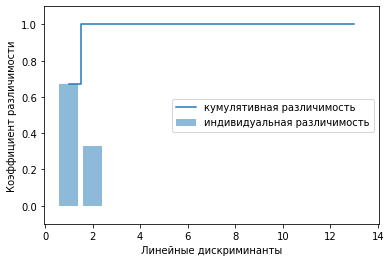

In [25]:
tot = sum(eigen_vals.real)
discr = [(i/tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)
plt.bar(range(1,14),discr, alpha=0.5, align='center', label='индивидуальная различимость')
plt.step(range(1,14), cum_discr, where='mid', label='кумулятивная различимость')
plt.ylabel('Коэффициент различимости')
plt.xlabel('Линейные дискриминанты')
plt.ylim([-0.1,1.1])
plt.legend(loc='best')
plt.show()

На графике видно, что первые два линейных дискриминанта без посторонней помощи захватывают 100% полезной информации. Далее создадим матрицу трансформации W

In [26]:
w = np.hstack((eigen_pairs[0][1][:,np.newaxis].real,eigen_pairs[1][1][:,np.newaxis].real,))
w

array([[-0.1481, -0.4092],
       [ 0.0908, -0.1577],
       [-0.0168, -0.3537],
       [ 0.1484,  0.3223],
       [-0.0163, -0.0817],
       [ 0.1913,  0.0842],
       [-0.7338,  0.2823],
       [-0.075 , -0.0102],
       [ 0.0018,  0.0907],
       [ 0.294 , -0.2152],
       [-0.0328,  0.2747],
       [-0.3547, -0.0124],
       [-0.3915, -0.5958]])

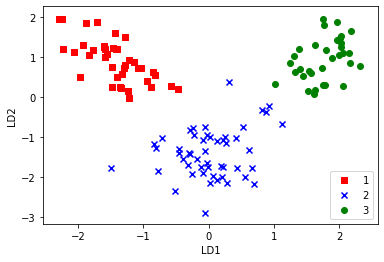

In [28]:
X_train_lda = X_train_std.dot(w)
# Далее трансформируем наши исходные данные 
colors = ['r','b','g']
markers = ['s','x','o']
for l,c,m in zip(np.unique(y_train),colors,markers):
    plt.scatter(X_train_lda[y_train==l,0],X_train_lda[y_train==l,1] * (-1),c=c, label=l, marker=m)
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.legend(loc='lower right')
plt.show()

In [31]:
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    #Настроим генератор маркеров и карту цветов
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red','blue','lightgreen','gray','cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # Вывести поверхность решения
    x1_min, x1_max = X[:,0].min() - 1, X[:,0].max() + 1
    x2_min, x2_max = X[:,1].min() - 1, X[:,1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min,x1_max, resolution),np.arange(x2_min,x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1,xx2,Z,alpha=0.3,cmap=cmap)
    plt.xlim(xx1.min(),xx1.max())
    plt.ylim(xx2.min(),xx2.max())
    
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x = X[y == cl,0], y = X[y == cl, 1], alpha=0.8,c=colors[idx], marker = markers[idx], label=cl, edgecolors='black')
        
    if test_idx:
        X_test, y_test = X[test_idx,:], y[test_idx]
        plt.scatter(X_test[:, 0], X_test[:, 1], c='',edgecolor='black',alpha=1.0, linewidths=1, marker='o',s=100, label='Испытательный набор')

In [30]:
# Рассмотрим реализацию sklearn
lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

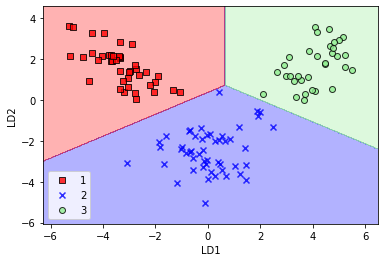

In [32]:
lr = LogisticRegression()
lr = lr.fit(X_train_lda, y_train)
plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.legend(loc='lower left')
plt.show()

In [1]:
X_test_lda = lda.transform(X_test_std)
plot_decision_regions(X_test_lda, y_test, classifier=lr)
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.legend(loc='lower left')
plt.show()

NameError: name 'lda' is not defined

На графике видно,что используя лишь двумерное подпространство признаков, а не исходные 13, классификатор на основе логистической регрессии способен достичь идеальной меры правильности. 